In [1]:
%load_ext ipycache

/Users/armin/miniconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/armin/miniconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# utility libraries
import numpy as np
from utils import *
from sklearn.linear_model import LogisticRegression
import pandas as pd
import pdb
import imp 
import time 
from sklearn.linear_model import LogisticRegression
from time import time
#parallelizing 
from joblib import Parallel, delayed
from pathos import multiprocessing 
from pathos.multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')
import sys

In [3]:
# Plotting libraries
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches
colors = np.array(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#650021"])
figSaveFile = "fig/"
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")


red = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
orange = (0.8, 0.7254901960784313, 0.4549019607843137)

# Offline

In [4]:
totDOs = 5
def offline(totCount, p, totDOs,f, bs, hs,x, eta): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((8,betaL.shape[0]))
    
    #betas[0,:] = center.avgLogistic()     # averaging 
    betas[1,:] = center.SQN(50,10,eta,bs,hs, max_iters=1000)   #SQN beta
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=eta)[0]      # simple sgd 
    betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=1, step=eta)[0]    #adagrad 
    betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=2, step=eta)[0]     #rms prop 
    betas[5,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=3, step=eta)[0]     #adadelta 
    #betas[6,:] = center.ADMM(1.0, max_iters=1000)    # admm 
    costs = np.zeros((8,3))
    for i in xrange(7):
        costs[i,:] = center.evaluate(betas[i,:])
    costs[7,:] = cost, roc, zeroone
    return costs

## Find optimal stepsize 

In [13]:
%%cache logstepsize.pkl stepsizeData 
etas = [0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0]
s = "step"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
stepsizeData = []
Ns = [1000, 10000]
bs = [20,50]
hs = [50,500]
pnum = 5
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for eta in etas:
        nnum= Ns[i]
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0, x[3], x[4],x[0],x[5])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps,[eta]*reps)
        results=p.map(f, keywords)
        stepsizeData.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

[Skipped the cell's code and loaded variables stepsizeData from file '/Users/armin/Documents/Bust_lab/online-regression/logstepsize.pkl'.]
97.6534969807 

109.112724066 

108.251772881 

111.292831898 

104.868330002 

114.977406979 

114.065120935 

127.830456972 

270.188333035 

316.65210104 

382.199267149 

290.478121996 

293.081700087 

286.233651876 

283.60848093 

283.256788969 

3293.75161505


In [17]:
totDOs = 5
def offline(totCount, p, totDOs,f, bs, hs,x, eta): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((8,betaL.shape[0]))
    
    #betas[0,:] = center.avgLogistic()     # averaging 
    #betas[1,:] = center.SQN(50,10,eta,bs,hs, max_iters=1000)   #SQN beta
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=eta)[0]      # simple sgd 
    #betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=1, step=eta)[0]    #adagrad 
    #betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=2, step=eta)[0]     #rms prop 
    #betas[5,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=3, step=eta)[0]     #adadelta 
    #betas[6,:] = center.ADMM(1.0, max_iters=1000)    # admm 
    costs = np.zeros((8,3))
    for i in xrange(7):
        costs[i,:] = center.evaluate(betas[i,:])
    costs[7,:] = cost, roc, zeroone
    return costs

etas = [500.0]
s = "step"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
stepsizeData = []
Ns = [1000, 10000]
bs = [20,50]
hs = [50,500]
pnum = 5
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for eta in etas:
        nnum= Ns[i]
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0, x[3], x[4],x[0],x[5])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps,[eta]*reps)
        results=p.map(f, keywords)
        stepsizeData.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

19.9515910149 

58.7902269363 

78.7447929382


In [7]:
%%cache logstepsizeDisc.pkl stepsizeDataDisc 
etas = [0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0]
s = "step"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
stepsizeDataDisc = []
Ns = [1000, 10000]
bs = [20,50]
hs = [50,500]
pnum = 5
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for eta in etas:
        nnum= Ns[i]
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,1.0, x[3], x[4],x[0],x[5])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps,[eta]*reps)
        results=p.map(f, keywords)
        stepsizeDataDisc.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

[Skipped the cell's code and loaded variables stepsizeDataDisc from file '/Users/armin/Documents/Bust_lab/online-regression/logstepsizeDisc.pkl'.]
116.686022997 

121.674641848 

123.607039213 

126.374697208 

126.766945839 

130.790445089 

128.65180397 

128.910499096 

385.213598013 

582.698642015 

490.532464981 

442.475939035 

369.693402052 

367.882862091 

397.226830006 

363.529162884 

4402.7176342


In [ ]:
 [0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0]

In [18]:
print np.mean(np.array(stepsizeData)[:,:,1:6,0], axis = 1)

[[ 0.69314718  0.21921477  0.69314718  0.69314718  0.69314718]
 [ 0.69314718  0.22752432  0.69314718  0.69314718  0.69314718]]


In [14]:
print np.mean(np.array(stepsizeData)[:,:,1:6,0], axis = 1)

[[ 0.1751432   0.69153351  0.60545587  0.26213745  0.2807262 ]
 [ 0.17562835  0.66832616  0.43665855  0.17995562  0.19396893]
 [ 0.1764889   0.64800721  0.34819822  0.17673431  0.18356608]
 [        nan  0.54712726  0.20871505  0.18162994  0.1800123 ]
 [        nan  0.47813114  0.18670704  0.19297932  0.18759572]
 [        nan  0.31673717  0.17701856  0.36027282  0.34463672]
 [        nan  0.26594875  0.17876914  0.64680372  0.60690839]
 [        nan  0.19703917  0.20321316  2.45899556  2.26702278]
 [ 0.18774923  0.6915361   0.60704556  0.27359324  0.29086174]
 [ 0.18788819  0.66879958  0.44414641  0.19135598  0.20557682]
 [ 0.18825376  0.64909496  0.35846736  0.1887368   0.19547048]
 [ 0.19262763  0.54977636  0.22147019  0.19268724  0.19159004]
 [        nan  0.48195293  0.19935843  0.20149371  0.19807725]
 [        nan  0.32432106  0.18909543  0.36929745  0.34412005]
 [        nan  0.27506277  0.18994697  0.64311351  0.61581583]
 [        nan  0.20870838  0.20381799  2.52571669  2.26

In [8]:
print np.mean(np.array(stepsizeDataDisc)[:,:,1:6,0], axis = 1) + np.mean(np.array(stepsizeData)[:,:,1:6,0], axis = 1)

[[  0.56269051   1.13689836   1.10465258   0.65014071   0.66879127]
 [  0.56377114   1.06123412   0.8345427    0.57083925   0.5838754 ]
 [  0.56547047   1.03709993   0.73771623   0.57075364   0.5766323 ]
 [         nan   0.93467051   0.59713647   0.62637695   0.61238342]
 [         nan   0.86566548   0.57611389   0.7397652    0.71225874]
 [         nan   0.70477223   0.57446285   2.33731769   2.09727909]
 [         nan   0.65471672   0.58841142   4.16374243   4.00134946]
 [         nan   0.59879196   0.9171754    9.6506857    9.32979626]
 [  0.59356663   1.14910208   1.109169     0.67974218   0.69697279]
 [  0.59396091   1.07843172   0.85635021   0.59927331   0.61329296]
 [  0.59466416   1.05571461   0.7651096    0.59942923   0.60544556]
 [         nan   0.95558098   0.62786169   0.6406167    0.64012176]
 [         nan   0.88776789   0.60640138   0.73131914   0.73440969]
 [         nan   0.73031821   0.60182746   2.15796169   2.08921012]
 [         nan   0.68130525   0.61122061   4.038

## best parameters are: sqn sgd ada rms adadelta
Observations:
* Regular SGD is highly sensitive the rest are not very sensitive 
Step-sizes 
.01,10,5,.05,.1

In [29]:
totDOs = 5
def offline(totCount, p, totDOs,f, bs, hs,x): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((7,betaL.shape[0]))
    
    betas[0,:] = center.avgLogistic()     # averaging 
    betas[1,:] = center.SQN(50,10,.01,bs,hs, max_iters=1000)   #SQN beta
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=200.0)[0]      # simple sgd 
    betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=1, step=5.0)[0]    #adagrad 
    betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=2, step=0.05)[0]     #rms prop 
    betas[5,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=3, step=.1)[0]     #adadelta 
    betas[6,:] = center.ADMM(1.0, max_iters=1000)    # admm 
    costs = np.zeros((8,3))
    for i in xrange(7):
        costs[i,:] = center.evaluate(betas[i,:])
    costs[7,:] = cost, roc, zeroone
    return costs

In [ ]:
df = pd.DataFrame(data=stepsizeData[7], columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
offline(1000, 6, totDOs,0.0, 20, 50,311313,50.0)

In [ ]:
df = pd.DataFrame(data=results, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
df = pd.DataFrame(data=df[['AVG','ADMM']], columns= ['AVG', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
np.random.seed(45141241)
repeats = 100
C1 = np.empty((repeats,8))
tstart = time()
for i in range(repeats):
    C1[i,:] = offline(10000,5,2,1,50,500)
tend = time()
print tend-tstart

In [ ]:
df = pd.DataFrame(data=C1, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
df = pd.DataFrame(data=df[['AVG','SQN','ADMM', 'ADAGRAD','RMSPROP']], columns= ['AVG','ADMM', 'SQN','ADAGRAD','RMSPROP'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
np.random.seed(321323)
repeats = 100
C2 = np.empty((repeats,8))
tstart = time()
for i in range(repeats):
    C2[i,:] = offline(1000,5,2,0,5,50)
tend = time()
print tend-tstart

In [ ]:
df = pd.DataFrame(data=C2, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
df = pd.DataFrame(data=df[['AVG','ADMM']], columns= ['AVG', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
np.random.seed(321323)
repeats = 100
C3 = np.empty((repeats,8))
tstart = time()
for i in range(repeats):
    C3[i,:] = offline(1000,5,6,0,5,50)
tend = time()
print tend-tstart

In [ ]:
df = pd.DataFrame(data=C3, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
df = pd.DataFrame(data=df[['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']], columns= 
                  ['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
np.random.seed(321323)
repeats = 100
C4 = np.empty((repeats,8))
tstart = time()
for i in range(repeats):
    C4[i,:] = offline(1000,5,11,0,5,50)
tend = time()
print tend-tstart

In [ ]:
df = pd.DataFrame(data=allpnResults0[7], columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

# p 1,2,5,10, N with 5 bins

In [30]:
%%cache allpnResults0.pkl allpnResults0 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allpnResults0 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        allpnResults0.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

[Saved variables allpnResults0 to file '/Users/armin/Documents/Bust_lab/online-regression/allpnResults0.pkl'.]
1 

240.311319113 

2 

596.210906029 

5 

714.934518099 

10 

614.746059895 

1 

560.109254122 

2 

673.849100113 

5 

701.316563845 

10 

1925.5615859 

1 

676.236349106 

2 

502.501229048 

5 

343.092593908 

10 

433.089289188 

7981.96131182


In [42]:
%%cache allpnResults1.pkl allpnResults1 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allpnResults1 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,1.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        allpnResults1.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

[Saved variables allpnResults1 to file '/Users/armin/Documents/Bust_lab/online-regression/allpnResults1.pkl'.]
1 

192.177781105 

2 

191.141917944 

5 

194.267288923 

10 

190.591035843 

1 

429.142810106 

2 

453.098579884 

5 

511.632159948 

10 

550.208417177 

2712.2617538


In [43]:
%%cache allpnResults0.5.pkl allpnResults05
s = "PNexp05"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allpnResults05 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0.5, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        allpnResults05.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

[Saved variables allpnResults05 to file '/Users/armin/Documents/Bust_lab/online-regression/allpnResults0.5.pkl'.]
1 

182.708810091 

2 

188.748991966 

5 

210.733844995 

10 

242.283838987 

1 

429.255162954 

2 

454.070144176 

5 

540.3508389 

10 

607.519734859 

2855.67299104


In [ ]:
allpnResults0 = np.array(allpnResults0)
print allpnResults0.shape
dat = allpnResults0

In [55]:
def df_from_pn(P,N, sim, DO=5):
    df = pd.DataFrame()
    result = pd.DataFrame()
    sim = np.array(sim)
    loss = ['cost', 'roc', '01']
    for i in range(3):
        for data in range(sim.shape[0]):
            p = P[data]
            n = N[data]
            cov = np.array([p-1]*sim.shape[1])
            cov.shape = (100,1)
            size = np.array([n]*sim.shape[1])
            size.shape = (100,1)
            r = np.array(range(100))
            r.shape = (100,1)
            l = np.array([i]*100)
            l.shape = (100,1)
            appended = np.hstack((sim[data,:,:,i],cov,size,r,l))
            if i == 0:
                appended = np.hstack((sim[data,:,:,i]*n,cov,size,r,l))
            else:
                appended = np.hstack((sim[data,:,:,i],cov,size,r,l))     
            df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n', 'range','loss']))
    
    df1 = df.loc[df.loss==0]
    df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df1['logistic'], axis=0))
    #df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]).div(df1['logistic']+ 10**-10, axis=0)
    df.loc[df.loss==0, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = np.log(np.abs(df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]))
    
    df1 = df.loc[df.loss==2]
    df.loc[df.loss==2, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].div(
        df1.logistic, axis=0)
    #df.drop("logistic", axis=1,inplace=True)
    
    df = pd.melt(df, id_vars=["covariates","n",'range', 'loss'])
    ####### TODO evaluate globally not locally 
    df = df[~np.isnan(df.value)]
    return df
    

In [56]:
def plot_pn(df,ylab,ylim):
    f, (ax) = plt.subplots(1, 1, sharex=True)
    sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df,color=colors,  err_style="ci_bars",ax=ax
           ,interpolate=True,legend=False)
    sns.set_context("notebook", font_scale=1.9, rc={"lines.linewidth": 2.5})
    plt.xlabel('\# of Covariates', fontsize=22)
    ax.set_ylabel(ylab, fontsize=32, labelpad=0)
    #ax.yaxis.set_label_coords(-.09, -.2)
    ax.set_ylim(ylim)  # most of the data
    ax.set_xlim(0.5, 10.5)  # outliers only
    plt.legend(loc='best')
    #ax.set(xticks=np.arange(1,10,2))
    ax.set_xticks(np.arange(1,10,2))
    ax.tick_params(labelsize=22)
    sns.set_style("ticks")
    plt.tight_layout()
    return f

In [ ]:
df = pd.DataFrame()
allpnResults0 = np.array(dat)
P = [2,3,6,11]
P = P + P + P
N = [1000] * 4 + [10000] * 4 + [100] * 4 
loss = ['cost', 'roc', '01']
i=0
for data in range(12):
    p = P[data]
    n = N[data]
    cov = np.array([p-1]*allpnResults0.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults0.shape[1])
    size.shape = (100,1)
    r = np.array(range(100))
    r.shape = (100,1)
    appended = np.hstack((allpnResults0[data,:,:,i],cov,size,r))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n', 'range']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)

In [ ]:
allpnResults0 = np.array(dat)
allpnResults0.shape

In [ ]:
df = pd.melt(df, id_vars=["covariates","n",'range'])

In [ ]:

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df[(df.n==1000)].drop("n", axis=1,inplace=False),color=colors,  err_style="ci_bars",ax=ax, 
           interpolate=False)
sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df[(df.n==1000)].drop("n", axis=1,inplace=False),color=colors,  err_style="ci_bars",ax=ax2
          ,legend=False, interpolate=True)

ax.axes.get_xaxis().set_visible(False)  #turnoff xaxis label for top graph
ax2.yaxis.label.set_visible(False)


ax.set_ylim(.05, .8)  # outliers only
ax2.set_ylim(0, .04)  # most of the data
ax.set_xlim(0, 10.5)  # outliers only
ax2.set_xlim(0, 10.5)  # most of the data
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)

ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xlabel('# of Covariates', fontsize=18)
ax.set_ylabel('Cost Function Difference', fontsize=16)
ax.yaxis.set_label_coords(-.09, -.2)
sns.plt.show()

In [ ]:
f, (ax) = plt.subplots(1, 1, sharex=True)
sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df[(df.n==100)],color=colors,  err_style="ci_bars",ax=ax
           ,interpolate=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.xlabel('# of Covariates', fontsize=18)
ax.set_ylabel('Cost Function Difference', fontsize=16)
#ax.yaxis.set_label_coords(-.09, -.2)
ax.set_ylim(0, .03)  # most of the data
ax.set_xlim(0.5, 10.5)  # outliers only
plt.legend(loc='best')
ax.set(xticks=np.arange(1,10,2))

sns.plt.show()

In [ ]:
P = [2,3,6,11]
P = P + P + P
N = [1000] * 4 + [10000] * 4 + [100] * 4

name, n, loss = 'allpnResults0', 100, 0
df = df_from_pn(P,N, allpnResults0)
ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')& (df.range != 67)],'Cost Function Difference',[-20,5])
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

In [ ]:
dat = np.array(allpnResults0).shape

In [ ]:
name, n, loss = 'allpnResults1', 100, 0
df = df_from_pn(P,N, allpnResults1)
ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic') & (df.range!=41) & (df.range != 88) ],'Cost Function Difference',[-0.005,.03])

UnboundLocalError: local variable 'x' referenced before assignment

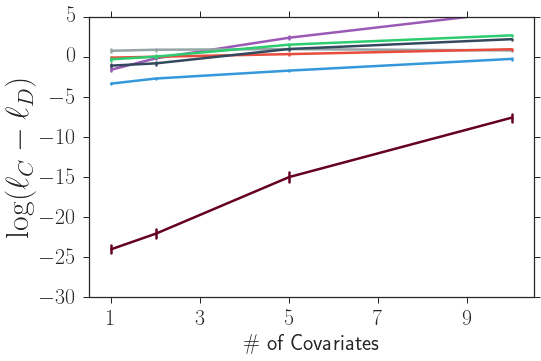

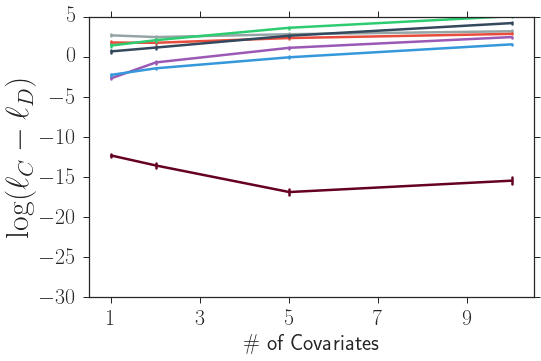

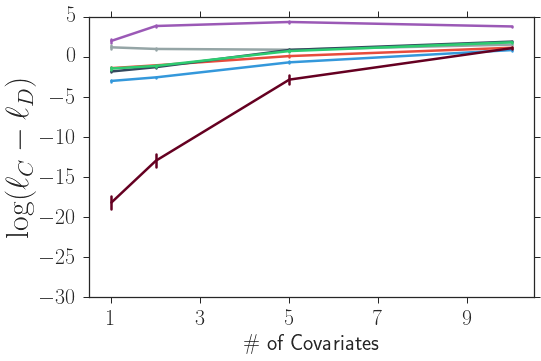

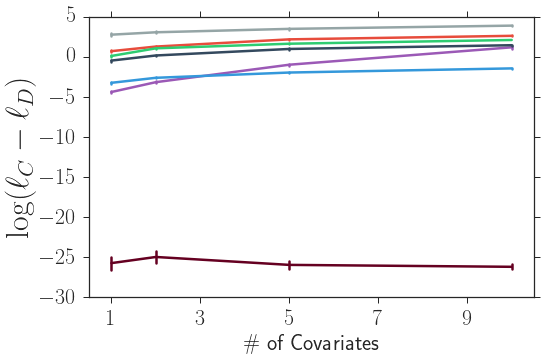

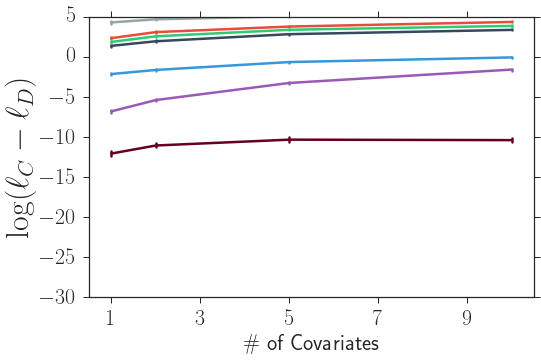

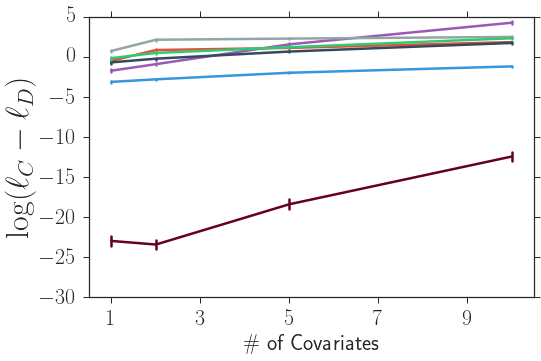

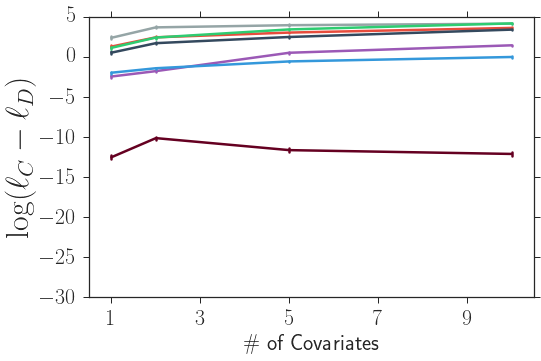

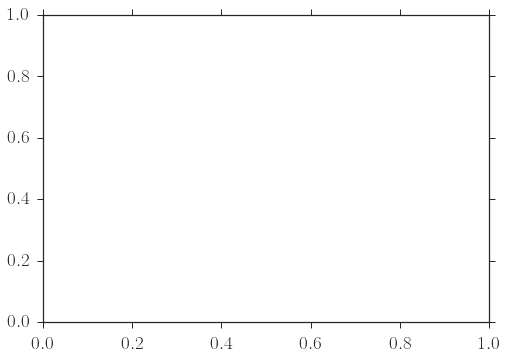

In [58]:
#Plotting 
plt.rc('text', usetex=True)

P = [2,3,6,11]
P = P + P + P
N = [1000] * 4 + [10000] * 4 + [100] * 4
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]

name, n, loss = 'allpnResults0', 1000, 0
df = df_from_pn(P,N, allpnResults0)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)

ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults0', 10000, 0
df = df_from_pn(P,N, allpnResults0)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults0', 100, 0
df = df_from_pn(P,N, allpnResults0)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic') & (df.range != 67)]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

#  this one needs special attention, one of the values ended up being nan, so we will delete that and relvant counts

name, n, loss = 'allpnResults1', 1000, 0
df = df_from_pn(P,N, allpnResults1)
df = df[(df.n==1000)& (df.loss==loss)& (df['range']!=79)]
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults1', 10000, 0
df = df_from_pn(P,N, allpnResults1)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

# name, n, loss = 'allpnResults1', 100, 0
# df = df_from_pn(P,N, allpnResults1)
# df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')& (df.range!=41) & (df.range != 88)]
# df1.value[np.isneginf(df1.value)] = np.nan 
# df1['value'].fillna((df1['value'].mean()), inplace=True)
# ax = plot_pn(df1,text,window)
# ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")


name, n, loss = 'allpnResults05', 1000, 0
df = df_from_pn(P,N, allpnResults05)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults05', 10000, 0
df = df_from_pn(P,N, allpnResults05)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults05', 100, 0
df = df_from_pn(P,N, allpnResults05)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")



# Time to convergence 

In [19]:
totDOs = 5
def timeoffline(totCount, p, totDOs,f, bs, hs,x): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
        
    iters = 1000
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((7,betaL.shape[0],iters/10+1))
    
    #betas[0,:,:] = center.avgLogistic()     # averaging 
    betas[1,:,:] = center.SQN(50,10,.01,bs,hs, max_iters=iters,verbose=True)   #SQN beta
    betas[2,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, step=200.0,verbose=True)     # simple sgd 
    betas[3,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=1, step=5.0,verbose=True)   #adagrad 
    betas[4,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=2, step=0.05,verbose=True)    #rms prop 
    betas[5,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=3, step=.1,verbose=True)     #adadelta 
    betas[6,:,:] = center.ADMM(1.0, max_iters=iters,verbose=True)    # admm 
    costs = np.zeros((8,3,iters/10+1))
    for i in xrange(7):
        for j in xrange(iters/10+1):
            costs[i,:,j] = center.evaluate(betas[i,:,j])
    for j in xrange(iters/10+1):
        costs[7,:,j] = cost, roc, zeroone
    return costs

In [20]:
%%cache alltimeResults0.pkl alltimeResults0 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
alltimeResults0 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        f = lambda x: timeoffline(x[1],x[2]+1,5,0.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
        sys.stdout.flush()
    alltimeResults0.append(temp)
print time()-t0

[Saved variables alltimeResults0 to file '/Users/armin/Documents/Bust_lab/online-regression/alltimeResults0.pkl'.]
1 

2 

5 

10 

1 

2 

5 

10 

1 

2 

5 

10 

4532.51225495


In [27]:
%%cache alltimeResults1.pkl alltimeResults1 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
alltimeResults1 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        f = lambda x: timeoffline(x[1],x[2]+1,5,1.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
        sys.stdout.flush()
    alltimeResults1.append(temp)
print time()-t0

[Saved variables alltimeResults1 to file '/Users/armin/Documents/Bust_lab/online-regression/alltimeResults1.pkl'.]
1 

2 

5 

10 

1 

2 

5 

10 

1 

2 

5 

10 

4076.33474302


In [28]:
%%cache alltimeResults05.pkl alltimeResults05 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
alltimeResults05 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        f = lambda x: timeoffline(x[1],x[2]+1,5,0.5, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
        sys.stdout.flush()
    alltimeResults05.append(temp)
print time()-t0

[Saved variables alltimeResults05 to file '/Users/armin/Documents/Bust_lab/online-regression/alltimeResults05.pkl'.]
1 

2 

5 

10 

1 

2 

5 

10 

1 

2 

5 

10 

4834.24504805


In [ ]:
reps = 100
alltimeResults05 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)

In [ ]:
np.array(alltimeResults0).shape

In [71]:
def df_convergance(P,N, sim, DO=5):
    df = pd.DataFrame()
    sim = np.array(sim)
    exps = sim.shape[2]
    tp = sim.shape[5]
    reshaped = np.empty((exps * tp,10))

    for k in range(1):
        for i,n in enumerate(N):
            for j,p in enumerate(P):
                for l in range(exps):
                    reshaped[l*tp:((l+1)*tp),:8] = sim[i,j,l,:,k,:].T
                    reshaped[l*tp:((l+1)*tp),8] = [l]*tp
                    reshaped[l*tp:((l+1)*tp),9] = range(0,tp*10,10)
                cov = np.array([p-1]*exps*tp,ndmin=2).T
                size = np.array([n]*exps*tp,ndmin=2).T
                #timepoint = np.array([np.array(range(100))]*tp,ndmin=2).reshape(10100,1)
                r = np.repeat(range(tp),exps).reshape(tp*exps,1)
                #l = np.array([i]*100,ndmin=2).T
                appended = np.hstack((reshaped,cov,size))
                df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM',
                                                                 'logistic', 'range', 'tps','covariates','n']))
    df1 = df
    df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df1['logistic'], axis=0))
    #df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]).div(df1['logistic']+ 10**-10, axis=0)
    df.loc[:, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]
    df = pd.melt(df, id_vars=["covariates","n",'range','tps'])
    logs = np.log(df.value)
    df.value = logs
    df.value[np.isnan(logs) & ~np.isfinite(logs)] = min(logs[~np.isnan(logs) & np.isfinite(logs)])
    return df

In [22]:
def plot_time(df,ylab,ylim):
    f, (ax) = plt.subplots(1, 1, sharex=True)
    sns.tsplot(time="tps", value="value", condition="variable",
           unit="range",data=df,color=colors[1:],  err_style="ci_band",ax=ax
           ,interpolate=True,legend=False)
    sns.set_context("notebook", font_scale=1.9, rc={"lines.linewidth": 2.5})
    plt.xlabel('Iterations', fontsize=22)
    ax.set_ylabel(ylab, fontsize=32, labelpad=-2)
    #ax.yaxis.set_label_coords(-.09, -.2)
    ax.set_ylim(ylim)  # most of the data
    ax.set_xlim(0, 1000)  # outliers only
    plt.legend(loc='best')
    ax.set_xticks(np.arange(0,1000,100))
    ax.tick_params(labelsize=22)
    sns.set_style("ticks")
    plt.tight_layout()
    return f

In [ ]:
df = df_convergance(Ps,Ns, alltimeResults05)

In [ ]:
plt.rc('text', usetex=True)

P = [2,3,6,11]
P = P + P + P
N = [1000] * 4 + [10000] * 4 + [100] * 4
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]


plot_time(df[(df.covariates==4)&(df.n==1000) & (df.variable!='logistic')],text,window)

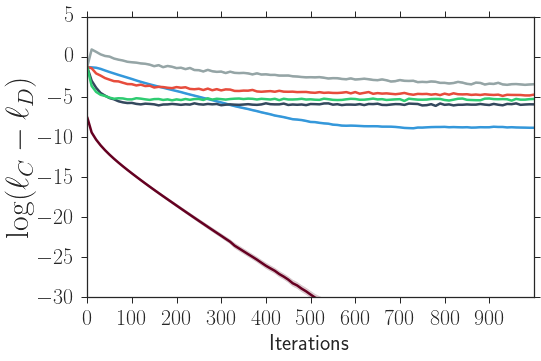

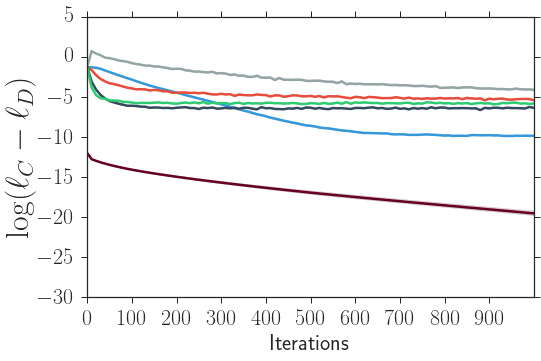

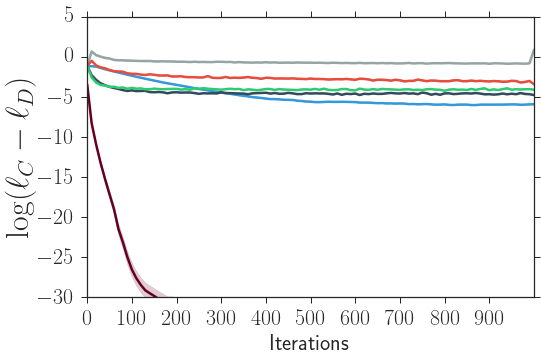

In [100]:
#Plotting 
plt.rc('text', usetex=True)

Ps = [1,2,5,10]
#N = [1000] * 4 + [10000] * 4 + [100] * 4
Ns = [1000, 10000, 100]
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]

name, n, p= 'alltimeResults1', 1000, 4
df = df_convergance(Ps,Ns, alltimeResults1)
ax = plot_time(df[(df.covariates==p)&(df.n==n) & (df.variable!='logistic') & (df.variable!='AVG')],text,window)
ax.savefig(figSaveFile+str(p)+name+"_"+str(n)+".png")

name, n, p= 'alltimeResults1', 10000, 4
df = df_convergance(Ps,Ns, alltimeResults1)
ax = plot_time(df[(df.covariates==p)&(df.n==n) & (df.variable!='logistic') & (df.variable!='AVG')],text,window)
ax.savefig(figSaveFile+str(p)+name+"_"+str(n)+".png")

name, n, p= 'alltimeResults1', 100, 4
df = df_convergance(Ps,Ns, alltimeResults1)
ax = plot_time(df[(df.covariates==p)&(df.n==n) & (df.variable!='logistic') & (df.variable!='AVG')],text,window)
ax.savefig(figSaveFile+str(p)+name+"_"+str(n)+".png")

In [ ]:
f, (ax) = plt.subplots(1, 1, sharex=True)
sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df[(df.n==1000)& (df.loss==loss)& (df['range']>80)],color=colors,  err_style="ci_bars",ax=ax
          ,interpolate=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax.set_xlim(0.5, 10.5)  # outliers only
ax.set_ylim(-0.001, .03) 



In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", data=df[(df.variable!="AVG") & (df.n==1000)]
               ,palette=colors[1:], legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p0_1000.png")

In [ ]:
ind = [1,3,6]
sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.variable!="RMSPROP") &(df.variable!="SGD") 
                       &(df.variable!="ADADELTA") &(df.variable!="AVG") & (df.n==1000)],
               palette=colors[ind])

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==10000)],
               palette=colors, legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p0_10000.png")

In [ ]:
ind=[0,2,3,6]
sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==10000)&(df.variable!="SGD")&(df.variable!="ADADELTA")&(df.variable!="RMSPROP")],
               palette=colors[ind])

In [105]:
totDOs = 5
def timejustone(totCount, p, totDOs,f, bs, hs,x): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
        
    iters = 10000
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((2,betaL.shape[0],iters/10+1))
    
    #betas[0,:,:] = center.avgLogistic()     # averaging 
    #betas[1,:,:] = center.SQN(50,10,.01,bs,hs, max_iters=iters,verbose=True)   #SQN beta
    #betas[2,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, step=200.0,verbose=True)     # simple sgd 
    betas[0,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=1, step=5.0,verbose=True)   #adagrad 
    #betas[4,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=2, step=0.05,verbose=True)    #rms prop 
    #betas[5,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=3, step=.1,verbose=True)     #adadelta 
    #betas[6,:,:] = center.ADMM(1.0, max_iters=iters,verbose=True)    # admm 
    costs = np.zeros((2,3,iters/10+1))
    for i in xrange(1):
        for j in xrange(iters/10+1):
            costs[i,:,j] = center.evaluate(betas[i,:,j])
    for j in xrange(iters/10+1):
        costs[1,:,j] = cost, roc, zeroone
    return costs

In [ ]:
s = "test"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
longtest= []
Ps = [2,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum
        f = lambda x: timejustone(x[1],x[2]+1,5,0.5, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
        sys.stdout.flush()
    longtest.append(temp)
print time()-t0

## Half and half

In [ ]:
df = pd.DataFrame()
allpnResults05 = np.array(allpnResults05)
P = [2,3,6,11]
P = P + P
N = [1000] * 4 + [10000] * 4

for data in range(8):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults05.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults05.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults05[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==1000)&(df.variable!="AVG")],
               palette=colors[1:], legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p05_1000.png")

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==10000)],
               palette=colors, legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p05_10000.png")

## All dosage 

In [ ]:
df = pd.DataFrame()
allpnResults1 = np.array(allpnResults1)
P = [2,3,6,11]
P = P + P
N = [1000] * 4 + [10000] * 4

for data in range(8):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults1.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults1.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults1[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==1000)&(df.variable!="AVG")],
               palette=colors[1:], legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p1_1000.png")

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==10000)],
               palette=colors, legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p1_10000.png")

# P2,5  N=1000: 10,000; 3,5,7,9

In [ ]:
%%cache allnResults0.pkl allnResults0
s = "repoexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allnResults0 = []
Ps = [1,2,5,10]
RepoSize = [3,5,7,9]
nnum = 10000
bs = 50
hs = 500
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(len(RepoSize)):
    for pnum in Ps:
        s = RepoSize[i]
        print s, '\n'
        tstart = time()
        f = lambda x: offline(10000,x[2]+1,x[1],0.0, x[3], x[4],x[0])
        keywords = zip([j*hs*RepoSize[i]*pnum*seed for j in inputs],[s]*reps, 
                       [pnum]*reps, [bs]*reps, [hs]*reps)
        results=p.map(f, keywords)
        allnResults0.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
%%cache allnResults05.pkl allnResults05
s = "repo5exp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allnResults05 = []
Ps = [1,2,5,10]
RepoSize = [3,5,7,9]
nnum = 10000
bs = 50
hs = 500
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(len(RepoSize)):
    for pnum in Ps:
        s = RepoSize[i]
        print s, '\n'
        tstart = time()
        f = lambda x: offline(10000,x[2]+1,x[1],0.5, x[3], x[4],x[0])
        keywords = zip([j*hs*RepoSize[i]*pnum*seed for j in inputs],[s]*reps, 
                       [pnum]*reps, [bs]*reps, [hs]*reps)
        results=p.map(f, keywords)
        allnResults05.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
%%cache allnResults1.pkl allnResults1
s = "rep1exp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allnResults1 = []
Ps = [1,2,5,10]
RepoSize = [3,5,7,9]
nnum = 10000
bs = 50
hs = 500
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(len(RepoSize)):
    for pnum in Ps:
        s = RepoSize[i]
        print s, '\n'
        tstart = time()
        f = lambda x: offline(10000,x[2]+1,x[1],0.5, x[3], x[4],x[0])
        keywords = zip([j*hs*RepoSize[i]*pnum*seed for j in inputs],[s]*reps, 
                       [pnum]*reps, [bs]*reps, [hs]*reps)
        results=p.map(f, keywords)
        allnResults1.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
df = pd.DataFrame()
allpnResults1 = np.array(allnResults0)[:,:,:,0]
P = [2,3,6,11]
P = P + P + P + P 
N = np.repeat(RepoSize,4)

for data in range(16):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults1.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults1.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults1[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="n", y="value", hue="variable", 
               data=df[(df.covariates==11)],
               palette=colors, legend=True)
ax.despine(left=True)
#plt.legend(loc='right')
ax.set(xlabel="# of DO's", ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"repos_p11_type0_size_10000.png")

In [ ]:
def df_from_results(P,N, sim, DO=[]):
    df = pd.DataFrame()
    result = pd.DataFrame()
    sim = np.array(sim)
    loss = ['cost', 'roc', '01']
    exps = sim.shape[0]
    if len(DO) == 0:
        DO = [5] * exps 
    for i in range(3):
        for data in range(exps):
            p = P[data]
            n = N[data]
            do = DO[data]
            cov = np.array([p-1]*sim.shape[1],ndmin=2).T
            size = np.array([n]*sim.shape[1],ndmin=2).T
            r = np.array(range(100),ndmin=2).T
            l = np.array([i]*100,ndmin=2).T
            num_do = np.array([do]*100,ndmin=2).T
            appended = np.hstack((sim[data,:,:,i],cov,size,r,l,num_do))
            df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM',
                                                                 'logistic','covariates','n', 'range','loss','do']))
    df1 = df.loc[df.loss==0]
    df1 = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df1['logistic'], axis=0)
    df.loc[df.loss==0, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]
    
    df1 = df.loc[df.loss==2]
    df.loc[df.loss==2, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 
                                                                                               'ADMM']].div(df1.logistic, axis=0)
    #df.drop("logistic", axis=1,inplace=True)
    df = pd.melt(df, id_vars=["covariates","n",'range', 'loss', 'do'])
    return df

In [ ]:
#Plotting 
P = [2,3,6,11]
P = P + P + P + P
N = [10000] * 16
DO = np.sort(RepoSize * 4)
df = df_from_results(P,N, allnResults0, DO=DO)

name, n, loss = 'allpnResults0', 1000, 0
ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')],'Cost Function Difference',[-0.005,.03])
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

In [ ]:
np.sort(RepoSize * 4)

In [ ]:
a = np.array([5]*100,ndmin=2).T
print a.shape

In [ ]:
df = pd.DataFrame()
allpnResults1 = np.array(allnResults05)
P = [2,3,6,11]
P = P + P + P + P 
N = np.repeat(RepoSize,4)

for data in range(16):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults1.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults1.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults1[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="n", y="value", hue="variable", 
               data=df[(df.covariates==2)],
               palette=colors, legend=True)
ax.despine(left=True)
#plt.legend(loc='right')
ax.set(xlabel="# of DO's", ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"repos_p2_type05_size_10000.png")

In [ ]:
%%cache allnResults05_1000.pkl allnResults05_1000
s = "repo5exp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allnResults05_1000 = []
Ps = [1,2,5,10]
RepoSize = [3,5,7,9]
nnum = 1000
bs = 20
hs = 50
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(len(RepoSize)):
    for pnum in Ps:
        s = RepoSize[i]
        print s, '\n'
        tstart = time()
        f = lambda x: offline(1000,x[2]+1,x[1],0.5, x[3], x[4],x[0])
        keywords = zip([j*hs*RepoSize[i]*pnum*seed for j in inputs],[s]*reps, 
                       [pnum]*reps, [bs]*reps, [hs]*reps)
        results=p.map(f, keywords)
        allnResults05_1000.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
df = pd.DataFrame()
allpnResults1 = np.array(allnResults05_1000)
P = [2,3,6,11]
P = P + P + P + P 
N = np.repeat(RepoSize,4)

for data in range(16):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults1.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults1.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults1[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="n", y="value", hue="variable", 
               data=df[(df.covariates==2)],
               palette=colors, legend=True)
ax.despine(left=True)
#plt.legend(loc='right')
ax.set(xlabel="# of DO's", ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"repos_p2_type05_size_1000.png")

# Extreme cases

In [ ]:
%%cache allpnResults0_100.pkl allpnResults0_100
s = "PNexp0100"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allpnResults0_100 = []
Ps = [1,2,5,10]
Ns = [100]
bs = [5]
hs = [10]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        allpnResults0_100.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
df = pd.DataFrame()
allpnResults05 = np.array(allpnResults0_100)
P = [2,3,6,11]
P = P 
N = [100] * 4 

for data in range(4):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults05.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults05.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults05[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", data=df[(df.variable!="AVG") & (df.n==100)]
               ,palette=colors[1:], legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
#ax.savefig(figSaveFile+"p0_1000.png")

# Linear Regression

In [ ]:
totDOs = 5
def offlineLasso(totCount, p, totDOs,f, bs, hs,x,logistic=False): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
    
    betaL,cost = all_logistic(center, False)
    betas = np.zeros((7,betaL.shape[0]))
    #pdb.set_trace()
    betas[0,:] = center.avgLinearReg()     # averaging 
    betas[1,:] = center.SQN(50,10,.05,bs,hs, max_iters=1000)   #SQN beta
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=0.1, logistic=False)[0]      # simple sgd 
    betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=1, step=0.1, logistic=False)[0]    #adagrad 
    betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=2, step=0.01,logistic=False)[0]     #rms prop 
    betas[5,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=3, step=0.1,logistic=False)[0]     #adadelta 
    betas[6,:] = center.ADMM(1.0, max_iters=1000,logistic=False)    # admm 
    print betas
    print betaL
    print beta
    costs = np.zeros(7)
    for i in xrange(7):
        costs[i] = center.evaluate(betas[i,:], logistic=False)
    return np.append(costs,cost)



In [ ]:
offlineLasso(1000, 5, totDOs,1.0, 20, 50,123)